In [1]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from typing import Callable, Optional
from probe_model import DRCProbe
from create_probe_dataset import ProbingDataset, ProbingDatasetCleaned
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import thinker
import thinker.viz_utils as viz
import thinker.util as util
import gym
import gym_sokoban
import torch.nn.functional as F
import pandas as pd
import numpy as np
from celluloid import Camera
from thinker.actor_net import DRCNet
import os
import random
from numpy.random import uniform

/home/tom/mlmi/dissertation/working_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-26 08:17:26,528	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



# Probe Single Squares

In [2]:
val_data = torch.load("./data/train_data_random.pt")
test_data = torch.load("./data/test_data_random.pt")

In [3]:
class MiniProbe(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(32,2, bias=False)
    def forward(self, x):
        return self.fc(x)

In [4]:
probe = MiniProbe()
optimiser = torch.optim.Adam(probe.parameters(), lr=3e-4)
loss_fnc = nn.CrossEntropyLoss()

In [4053]:
results = {}
feature = "tar_next"
alt_feature = "justtar_loc"
pct_keep = 1
for name, c in [("xenc", 192), ("layer0", 32), ("layer1", 96), ("layer2", 160)]:

    probe = MiniProbe()
    optimiser = torch.optim.Adam(probe.parameters(), lr=3e-4)
    loss_fnc = nn.CrossEntropyLoss()
    
    print(f" ===== {name} ======")
    sup_data = []
    for trans in val_data.data:
        if len(trans[alt_feature]) > 1:
            next_loc = trans[feature][0]
            #next_loc = trans[feature]
            other_loc = random.choice([t_loc for t_loc in trans[alt_feature] if t_loc!=next_loc])
            next_loc_x = next_loc % 8
            next_loc_y = (next_loc - next_loc_x) // 8
            other_loc_x = other_loc % 8
            other_loc_y = (other_loc - other_loc_x) // 8
            next_tar_vec = trans["hidden_states"][-1,c:c+32,next_loc_y, next_loc_x]
            other_tar_vec = trans["hidden_states"][-1,c:c+32,other_loc_y, other_loc_x]
            diff_tar_vec = next_tar_vec - other_tar_vec
            if uniform(0,1) < pct_keep:
                sup_data.append((next_tar_vec, 1))
                sup_data.append((other_tar_vec, 0))
    train_dataset = ProbingDatasetCleaned(sup_data)

    sup_data = []
    for trans in test_data.data:
        if len(trans[alt_feature]) > 1:
            next_loc = trans[feature][0]
            #next_loc = trans[feature]
            other_loc = random.choice([t_loc for t_loc in trans[alt_feature] if t_loc!=next_loc])
            next_loc_x = next_loc % 8
            next_loc_y = (next_loc - next_loc_x) // 8
            other_loc_x = other_loc % 8
            other_loc_y = (other_loc - other_loc_x) // 8
            next_tar_vec = trans["hidden_states"][-1,c:c+32,next_loc_y, next_loc_x]
            other_tar_vec = trans["hidden_states"][-1,c:c+32,other_loc_y, other_loc_x]
            diff_tar_vec = next_tar_vec - other_tar_vec
            if uniform(0,1) < pct_keep:
                sup_data.append((next_tar_vec, 1))
                sup_data.append((other_tar_vec, 0))
    test_dataset = ProbingDatasetCleaned(sup_data)

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=16)

    probe = MiniProbe()
    optimiser = torch.optim.Adam(probe.parameters(), lr=3e-4)
    loss_fnc = nn.CrossEntropyLoss()

    for epoch in range(300):
        for vecs, labs in train_loader:
            optimiser.zero_grad()
            logits = probe(vecs)
            loss = loss_fnc(logits, labs)
            loss.backward()
            optimiser.step()
        
        if epoch % 50 == 0:
            with torch.no_grad():
                running_acc = 0
                for vecs, labs in test_loader:
                    logits = probe(vecs)
                    running_acc += torch.sum(logits.argmax(dim=1) == labs).item()
                print(running_acc / len(test_dataset.data))
    results[name] = {"test acc": round(running_acc / len(test_dataset.data), 3), "weights": probe.fc.weight.tolist()}
pd.DataFrame(results).to_csv(f"./squarelevelproberesults/{feature}.csv")

 ===== xenc ======
0.49141630901287553
0.5536480686695279
0.5429184549356223
0.5472103004291845
0.5536480686695279
0.5450643776824035
 ===== layer0 ======
0.6180257510729614
0.7253218884120172
0.7167381974248928
0.721030042918455
0.7253218884120172
0.7296137339055794
 ===== layer1 ======
0.5515021459227468
0.7167381974248928
0.7103004291845494
0.7081545064377682
0.7124463519313304
0.7124463519313304
 ===== layer2 ======
0.572961373390558
0.723175965665236
0.721030042918455
0.7124463519313304
0.7081545064377682
0.7060085836909872


### Results

In [2914]:
feature = "next_start_move_box_loc"
results_df = pd.read_csv(f"./squarelevelproberesults/{feature}.csv", index_col=0)

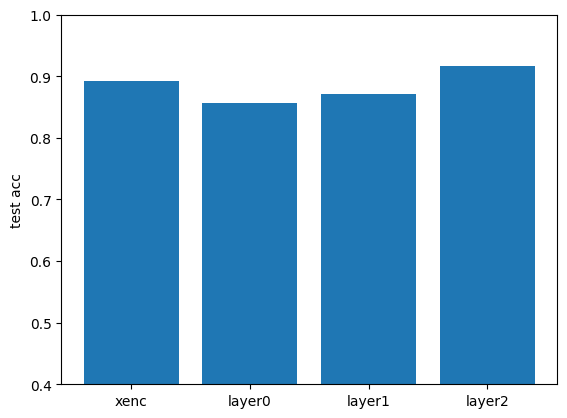

In [2915]:
plt.bar(height=[float(c) for c in results_df.iloc[0,:].tolist()], x=range(4))
plt.xticks(range(4), [c[0] for c in [("xenc", 192), ("layer0", 32), ("layer1", 96), ("layer2", 160)]])
plt.ylim(0.4,1)
plt.ylabel("test acc")
plt.show()

# Intervene On Single Squares

In [845]:
from thinker.actor_net import sample
class ActPatchDRCNet:

    def __init__(self, drc_net):
        self.drc_net = drc_net

    def forward_normal(self, env_out, rnn_state):
        return self.drc_net(env_out, rnn_state)
    
    def forward_patch(self, env_out, rnn_state, greedy=True, activ_type=None, patch_dict={}, activ_ticks=[], activs=None):
        
        activ_layers = list(patch_dict.keys())

        done = env_out.done
        T, B = done.shape
        x = self.drc_net.normalize(env_out.real_states.float())
        x = torch.flatten(x, 0, 1)
        x_enc = self.drc_net.encoder(x)
        core_input = x_enc.view(*((T, B) + x_enc.shape[1:]))

        record_state=self.drc_net.record_state

        assert len(core_input.shape) == 5
        core_output_list = []
        reset = done.float()
        if self.drc_net.record_state: 
            self.drc_net.core.hidden_state = []
            self.drc_net.core.hidden_state.append(torch.concat(rnn_state, dim=1)) 
        for n, (x_single, reset_single) in enumerate(
            zip(core_input.unbind(), reset.unbind())
        ):
            for t in range(self.drc_net.core.tran_t):
                if t > 0:
                    reset_single = torch.zeros_like(reset_single)
                reset_single = reset_single.view(-1)
                if t in activ_ticks and (0 in activ_layers or 1 in activ_layers or 2 in activ_layers):
                    #print(f"----- patching activations for tick {t} ---- ")
                    output, rnn_state = self.forward_single_patch(
                        x=x_single,
                        core_state=rnn_state,
                        reset=reset_single,
                        activ_type=activ_type, 
                        patch_dict=patch_dict,
                        activs=activs[:,t,:,:,:]
                    )  # output shape: 1, B, core_output_size
                else:
                    output, rnn_state = self.drc_net.core.forward_single(
                        x_single, rnn_state, reset_single, reset_single
                    )        
                if self.drc_net.record_state: self.drc_net.core.hidden_state.append(torch.concat(rnn_state, dim=1))      
            core_output_list.append(output)
        core_output = torch.cat(core_output_list)
        if self.drc_net.record_state: 
           self.drc_net.core.hidden_state = torch.stack(self.drc_net.core.hidden_state, dim=1)

        core_output = torch.flatten(core_output, 0, 1)

        if activ_type == "xenc" and 3 in activ_layers and 2 in activ_ticks:
            #print(f"--- Patching Layer 3 ---")
            #### activ_channels = [192+ c patch_dict[3]]
            patch_channels = patch_dict[3]
            x_enc[:,patch_channels,:,:] = activs[:,-1,[192+c for c in patch_channels],:,:]

        core_output = torch.cat([x_enc, core_output], dim=1)

        core_output = torch.flatten(core_output, 1)
        final_out = torch.nn.functional.relu(self.drc_net.final_layer(core_output))
        pri_logits = self.drc_net.policy(final_out)
        pri_logits = pri_logits.view(T*B, self.drc_net.dim_actions, self.drc_net.num_actions)
        pri_probs = torch.nn.functional.softmax(pri_logits.view(-1), dim=0)
        pri = sample(pri_logits, greedy=greedy, dim=-1)
        pri = pri.view(T, B, self.drc_net.dim_actions) 
        pri_env = pri[-1, :, 0] if not self.drc_net.tuple_action else pri[-1]   
        action = pri_env
        return action, pri_probs, pri_logits.view(-1), rnn_state
    
    def forward_single_patch(self, x, core_state, reset, activ_type=None, patch_dict={}, activs=None):
        reset = reset.float()

        activ_layers = list(patch_dict.keys())

        b, c, h, w = x.shape
        layer_n = 2
        out = core_state[(self.drc_net.core.num_layers - 1) * layer_n] * (1 - reset).view(
            b, 1, 1, 1
        )  # h_cur on last layer

        core_out = []
        new_core_state = []
        for n, cell in enumerate(self.drc_net.core.layers):
            cell_input = torch.concat([x, out], dim=1)
            h_cur = core_state[n * layer_n + 0] * (1 - reset.view(b, 1, 1, 1))
            c_cur = core_state[n * layer_n + 1] * (1 - reset.view(b, 1, 1, 1))
        
            if n in activ_layers and activ_type is not None:
                #print(f"--- Patching Layer {n} ---")
                patch_channels = patch_dict[n]
                if activ_type == "xenc":
                    patch_activs = activs[:,[192+c for c in patch_channels],:,:].detach().clone()
                elif activ_type == "hidden":
                    patch_activs = activs[:,[64*n+c for c in patch_channels],:,:].detach().clone()
                elif activ_type == "cell":
                    patch_activs = activs[:,[64*n+32+c for c in patch_channels],:,:].detach().clone()

                if activ_type == "xenc" and n in activ_layers:
                    #print(f"patching channels {patch_channels} in xenc")
                    cell_input[:,patch_channels,:,:] = patch_activs

                #print("out, x, cell_input:", out.sum(), x.sum(), cell_input.sum())

                h_next, c_next = self.forward_cell_patch(
                    convlstm_cell=cell,
                    input=cell_input,
                    h_cur=h_cur,
                    c_cur=c_cur,
                    activ_type=activ_type,
                    patch_channels=patch_channels, 
                    patch_activs=patch_activs
                )
            else:
                #print(f"--- NOT patching layer {n} ---")
                h_next, c_next, concat_k, concat_v = cell(
                    cell_input, h_cur, c_cur, None, None, None
                )
            if self.drc_net.core.grad_scale < 1 and h_next.requires_grad:
                h_next.register_hook(lambda grad: grad * self.drc_net.core.grad_scale)
                c_next.register_hook(lambda grad: grad * self.drc_net.core.grad_scale)
            new_core_state.append(h_next)
            new_core_state.append(c_next)
            out = h_next

        core_state = tuple(new_core_state)
        core_out = out.unsqueeze(0)
        return core_out, core_state
    
    def forward_cell_patch(self, convlstm_cell, input, h_cur, c_cur, activ_type=None, patch_channels=[], patch_activs=None):
        B = input.shape[0]
        #print("h_cur, c_cur, input", h_cur.sum(), c_cur.sum(), input.sum())
        combined = torch.cat([input, h_cur], dim=1)  # concatenate along channel axis
        if convlstm_cell.pool_inject:
            combined = torch.cat(
                [combined, convlstm_cell.proj_max_mean(h_cur)], dim=1
            )  # concatenate along channel axis
        if convlstm_cell.linear:
            combined_conv = convlstm_cell.main(combined[:, :, 0, 0]).unsqueeze(-1).unsqueeze(-1)
        else:
            combined_conv = convlstm_cell.main(combined)
        cc_i, cc_f, cc_o, cc_g, cc_a = torch.split(combined_conv, convlstm_cell.embed_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        #print("c_next:", c_next.sum())
        if activ_type=="cell":
            #print(f"patching channels {patch_channels} in cell")
            c_next[:,patch_channels,:,:] = patch_activs
        h_next = o * torch.tanh(c_next)
        if activ_type=="hidden":
            #print(f"patching channels {patch_channels} in hidden")
            h_next[:,patch_channels,:,:] = patch_activs
        #print(h_next.sum())

        return h_next, c_next

Initializing env 0 with device cpu


Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Sokoban-v0


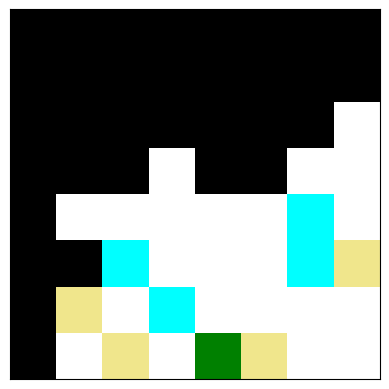

In [3647]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False

env = thinker.make(
    "Sokoban-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)

# run the trained drc again
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
#actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
#state, reward, done, info = env.step(actor_out.action)
#env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
#actor_out, new_rnn_state = drc_net(env_out, rnn_state, greedy=True)
viz.plot_mini_sokoban(state["real_states"][0])

In [4126]:
def plot_interv(layer, state, hidden_states):
    #weight = torch.tensor([[-0.48737913370132446, 2.0204238891601562, -0.20710276067256927, -0.1559930294752121, -1.4778072834014893, 1.0226231813430786, -0.011008787900209427, 0.26454436779022217, 0.5662028789520264, 0.826072633266449, 0.7518832087516785, 0.4854520261287689, -0.545423686504364, -0.1605425626039505, -2.30305552482605, 0.10711660981178284, -0.20925910770893097, -0.4371994435787201, -0.09227673709392548, 0.2594224214553833, 0.09071329236030579, -0.10446739196777344, -0.008032598532736301, -0.6721022725105286, 0.14969028532505035, -0.5917406678199768, 0.7830581068992615, -0.018811164423823357, 0.2390570491552353, 0.2955656945705414, -1.1725964546203613, 0.9227076768875122], [0.6500030755996704, -1.9482715129852295, 0.21371221542358398, -0.007815630175173283, 1.2696133852005005, -0.7610629200935364, 0.0742838978767395, -0.525004506111145, -0.3204478919506073, -0.8447422981262207, -0.5190479755401611, -0.7739930152893066, 0.6830257177352905, 0.15014739334583282, 2.5916659832000732, -0.32344695925712585, 0.09805583208799362, 0.6653913259506226, 0.010809963569045067, -0.0951007530093193, 0.04532609134912491, -0.021794166415929794, 0.18280953168869019, 0.7764242887496948, -0.0533781498670578, 0.40867361426353455, -0.7241909503936768, 0.18064184486865997, -0.30017533898353577, -0.36463192105293274, 1.2368476390838623, -0.9249445199966431]])
    weight = torch.tensor([[1.7741026878356934, 0.23829807341098785, -0.4765743911266327, -0.3090250790119171, -0.33118438720703125, -2.8092799186706543, 0.16634029150009155, -1.807407021522522, -0.13387714326381683, -0.34786245226860046, 0.657535195350647, -0.5856123566627502, 0.4517926871776581, -0.9095766544342041, -0.10291017591953278, -0.09858949482440948, -0.35263383388519287, -1.615708351135254, -0.7799985408782959, 1.6272573471069336, -0.012647507712244987, 0.02794782631099224, 0.0159939993172884, 1.9977424144744873, -0.2700195610523224, -0.38910531997680664, -0.1412203162908554, -0.09455776959657669, 0.39089444279670715, -0.37262558937072754, 0.6665008664131165, -0.7619373798370361], [-2.0696938037872314, -0.38802820444107056, 0.5280684232711792, 0.23703162372112274, 0.3948691189289093, 2.719857692718506, -0.12987162172794342, 1.7273046970367432, 0.014804677106440067, 0.12781506776809692, -0.47968780994415283, 0.5010322332382202, -0.5012488961219788, 0.7640618681907654, 0.2018471658229828, 0.030183838680386543, 0.4156574606895447, 1.6790746450424194, 0.6045333743095398, -1.8027441501617432, -0.30582278966903687, -0.2585926949977875, -0.027122506871819496, -1.7820113897323608, 0.23489412665367126, 0.4310240149497986, 0.10243157297372818, -0.05739375576376915, -0.1980225145816803, 0.543531596660614, -0.8056098222732544, 0.7186568379402161]])
    channels = list(range(32))
    if layer == 0:
        c = 32
    elif layer == 1:
        c = 96
    elif layer == 2:
        c = 160
    fig, axs = plt.subplots(1,2)
    map = torch.zeros(size=(2,8,8))
    for i in range(len(channels)):
        map[0] += hidden_states[-1,c+channels[i],:,:] * weight[0,i]
        map[1] += hidden_states[-1,c+channels[i],:,:] * weight[1,i]
    if state.shape[0] != state.shape[1]:
        state = state.permute(1,2,0)
    dim_z = 7
    mini_board = np.zeros(state.shape[:-1])
    for i in range(1,1+dim_z):
        mini_board[(state[:,:,i-1] == 1)] = i
    mini_board = np.flip(mini_board, axis=0)
    cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
    bounds= [i+0.5 for i in range(1+dim_z)]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    axs[0].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[0].axes.get_yaxis().set_visible(False)
    axs[0].axes.get_xaxis().set_visible(False)
    axs[1].imshow(map.argmax(dim=0), vmin=-1,vmax=1)
    axs[1].axes.get_yaxis().set_visible(False)
    axs[1].axes.get_xaxis().set_visible(False)

tensor([0.0091, 0.0057, 0.0047, 0.9738, 0.0067], grad_fn=<SoftmaxBackward0>)


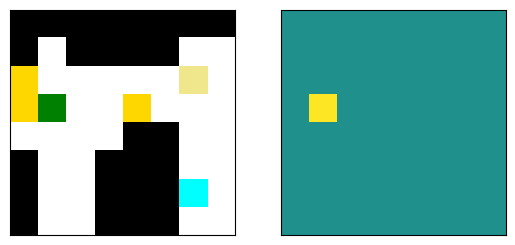

In [4329]:
layer = 2
alpha = 50
if layer == 0:
    c1, c2 = 32,64
elif layer == 1:
    c1, c2 = 96,128
elif layer == 2:
    c1, c2 = 160,192

patch_net = ActPatchDRCNet(drc_net)
patch_dict = {layer: list(range(32))}
actor_out, new_rnn_state = drc_net(env_out, rnn_state, greedy=True)
activs = drc_net.hidden_state.detach().clone()
#activs[:,:,160:192,6,1] += 5*torch.tensor(results["layer2"]["weights"][0])#
#activs[:,:,160:192,6,2] += 50*torch.tensor(results["layer2"]["weights"][0])
#activs[:,:,c1:c2,6,1] += alpha*torch.tensor(results[f"layer{layer}"]["weights"][0])
#activs[:,:,c1:c2,5,0] += alpha*torch.tensor(results[f"layer{layer}"]["weights"][0])
#activs[:,:,c1:c2,4,5] += alpha*torch.tensor(results[f"layer{layer}"]["weights"][1])
#activs[:,:,c1:c2,4,7] -= alpha*torch.tensor(results[f"layer{layer}"]["weights"][1])
#activs[:,:,c1:c2,5,5] += alpha*torch.tensor(results[f"layer{layer}"]["weights"][1])

patch_action, patch_action_probs, patch_logits, rnn_state = patch_net.forward_patch(env_out, rnn_state, activ_type="cell", activ_ticks=[0,1,2],
                                                                    patch_dict=patch_dict, activs=activs)
state, reward, done, info = env.step(patch_action)
env_out = util.create_env_out(patch_action, state, reward, done, info, flags)
#viz.plot_mini_sokoban(state["real_states"][0])
plot_interv(2, state["real_states"][0], activs[0])
print(patch_action_probs)